
# Robust Regression Models for GPS-Embedded Mobile Map Interaction

This notebook fits **robust regression** models (Huber-T loss) for two outcomes:
- **Interaction frequency**: `tap_rate_z`
- **Interaction regularity**: `cv_iti_z`

Predictors include urban form metrics and individual traits:
- `orientation_entropy_z`, `closeness_log_z`, `betweenness_log_z`, `degree_mean_z`, `circuity_log_z`
- `SA_z` (spatial anxiety), `SBSOD_z` (sense of direction), and `Gender_M`

It produces:
- Fitted model summaries (text files)
- Cross-validated performance (GroupKFold by `partId`) using Median Absolute Deviation (MAD)
- Diagnostic plots (histogram of residuals, Q–Q plot, residuals vs fitted)


In [13]:

# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from sklearn.model_selection import GroupKFold

# Repro settings
np.random.seed(42)

# Paths
DATA_PATH = Path("../data/pre-processed_anonimized_final_clean.csv")
# Structured results directory
OUTPUT_DIR = Path("outputs") / "regression"
(OUTPUT_DIR / "figs").mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "summaries").mkdir(parents=True, exist_ok=True)

# OUTPUT_DIR = Path("outputs")
# OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
# os.makedirs("./outputs/regression", exist_ok=True)

print(f"Python version: {os.sys.version.split()[0]}\nStatsmodels: {sm.__version__}")
print(f"Data path: {DATA_PATH.resolve() if DATA_PATH.exists() else DATA_PATH}")
print(f"Outputs will be saved under: {OUTPUT_DIR.resolve()}")


Python version: 3.11.14
Statsmodels: 0.14.5
Data path: /Users/donatellazingaro/TSAS_Special_Issue_Urban_Mobility/data/pre-processed_anonimized_final_clean.csv
Outputs will be saved under: /Users/donatellazingaro/TSAS_Special_Issue_Urban_Mobility/notebooks/outputs/regression


In [14]:

# Load data
df = pd.read_csv(DATA_PATH)
# Standardize
scaler = StandardScaler()
df[['SA_z', 'SBSOD_z']] = scaler.fit_transform(df[['SA_Score', 'SBDS_score']])

print("\n=== Basic Info ===")
print(df.shape)
display(df.head(3))

expected_cols = [
    'partId','tap_rate_z','cv_iti_z','orientation_entropy_z','closeness_log_z','betweenness_log_z',
    'degree_mean_z','circuity_log_z','SA_z','SBSOD_z'
]

missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Gender handling
if 'Gender_M' not in df.columns:
    if 'Gender' in df.columns:
        df['Gender_M'] = (df['Gender'].astype(str).str.upper().str[0] == 'M').astype(float)
    else:
        # If no Gender label present, default to NaN (will be dropped in complete cases)
        df['Gender_M'] = np.nan

# Ensure numeric types
for col in ['tap_rate_z','cv_iti_z','orientation_entropy_z','closeness_log_z','betweenness_log_z',
            'degree_mean_z','circuity_log_z','SA_z','SBSOD_z','Gender_M']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n=== Column dtypes (selected) ===")
print(df[['tap_rate_z','cv_iti_z','Gender_M']].dtypes)



=== Basic Info ===
(2442, 27)


,partId,session_id,application,category,betweenness_mean,circuity,closeness_mean,degree_mean,orientation_entropy,betweenness_log_z,...,mean_iti,cv_iti,tap_rate_z,cv_iti_z,SBDS_score,Age,Gender,SA_Score,SA_z,SBSOD_z
0,P001,S001,"['com.google.android.apps.maps', 'com.google.a...","['TRAVEL_AND_LOCAL', 'TRAVEL_AND_LOCAL', 'TRAV...",0.025317,1.066209,0.074164,5.312715,1.017604,-0.536308,...,5.105333,0.560183,-0.879134,-0.519456,5.4,25-34,M,1.46,-1.172893,0.292713
1,P001,S002,"['com.google.android.apps.maps', 'com.google.a...","['TRAVEL_AND_LOCAL', 'TRAVEL_AND_LOCAL', 'TRAV...",0.031228,1.038986,0.072083,5.319588,0.924515,-0.464403,...,1.636125,0.680571,-0.047426,-0.338614,5.4,25-34,M,1.46,-1.172893,0.292713
2,P001,S003,"['com.google.android.apps.maps', 'com.google.a...","['TRAVEL_AND_LOCAL', 'TRAVEL_AND_LOCAL', 'TRAV...",0.030902,1.087172,0.053342,5.378049,0.968300,-0.468363,...,1.408412,0.823135,0.047692,-0.140514,5.4,25-34,M,1.46,-1.172893,0.292713



=== Column dtypes (selected) ===
tap_rate_z    float64
cv_iti_z      float64
Gender_M      float64
dtype: object


In [15]:

# Define four model specifications (2 outcomes × 2 network centralities)
models_dict = {
    "Tap_Betweenness": {
        "target": "tap_rate_z",
        "predictors": [
            "orientation_entropy_z",
            "betweenness_log_z",
            "degree_mean_z",
            "circuity_log_z",
            "SA_z",
            "SBSOD_z",
            "Gender_M"
        ],
    },
    "Tap_Closeness": {
        "target": "tap_rate_z",
        "predictors": [
            "orientation_entropy_z",
            "closeness_log_z",
            "degree_mean_z",
            "circuity_log_z",
            "SA_z",
            "SBSOD_z",
            "Gender_M"
        ],
    },
    "CV_Closeness": {
        "target": "cv_iti_z",
        "predictors": [
            "orientation_entropy_z",
            "closeness_log_z",
            "degree_mean_z",
            "circuity_log_z",
            "SA_z",
            "SBSOD_z",
            "Gender_M"
        ],
    },
    "CV_Betweenness": {
        "target": "cv_iti_z",
        "predictors": [
            "orientation_entropy_z",
            "betweenness_log_z",
            "degree_mean_z",
            "circuity_log_z",
            "SA_z",
            "SBSOD_z",
            "Gender_M"
        ],
    },
}

# Determine intersection of complete cases across all models
needed = set(['partId'])
for spec in models_dict.values():
    needed.update(spec['predictors'])
    needed.add(spec['target'])

mask = df[list(needed)].notna().all(axis=1)
df_clean = df[mask].reset_index(drop=True)
print(f"\n✅ Final sample size for all models (complete cases): {len(df_clean)} sessions")

groups = df_clean['partId']
n_groups = groups.nunique()
print(f"Unique participants (groups): {n_groups}")



✅ Final sample size for all models (complete cases): 2399 sessions
Unique participants (groups): 46


In [16]:

def fit_rlm(X, y):
    Xc = sm.add_constant(X, has_constant='add')
    model = sm.RLM(y, Xc, M=HuberT()).fit()
    return model

def compute_mad(model, y):
    return np.median(np.abs(model.fittedvalues - y))

def compute_pseudo_r2(model, y):
    ss_total = ((y - y.mean()) ** 2).sum()
    ss_resid = ((y - model.fittedvalues) ** 2).sum()
    return 1 - (ss_resid / ss_total) if ss_total > 0 else np.nan

def compute_cv_mad(X, y, groups, n_splits=10):
    # Adjust splits to be feasible with the number of groups
    n_unique = groups.nunique()
    k = min(n_splits, n_unique)
    if k < 3:
        k = max(2, k)  # ensure at least 2 splits if possible
    gkf = GroupKFold(n_splits=k)
    mads = []
    for train_idx, test_idx in gkf.split(X, y, groups):
        X_tr = sm.add_constant(X.iloc[train_idx], has_constant='add')
        X_te = sm.add_constant(X.iloc[test_idx], has_constant='add')
        model_cv = sm.RLM(y.iloc[train_idx], X_tr, M=HuberT()).fit()
        preds = model_cv.predict(X_te)
        mads.append(np.median(np.abs(preds - y.iloc[test_idx])))
    return float(np.mean(mads)), float(np.std(mads))


In [17]:
results = []

# Summary output folder for regression models
summaries_dir = OUTPUT_DIR / "regression" / "summaries"
summaries_dir.mkdir(parents=True, exist_ok=True)

for name, spec in models_dict.items():
    y = df_clean[spec["target"]].astype(float)
    X = df_clean[spec["predictors"]].astype(float)

    model = fit_rlm(X, y)

    # Save full model summary
    summary_path = summaries_dir / f"{name}_summary.txt"
    with open(summary_path, "w") as f:
        f.write(model.summary().as_text())

    mad = compute_mad(model, y)
    r2 = compute_pseudo_r2(model, y)
    cv_mean, cv_sd = compute_cv_mad(X, y, groups)

    results.append({
        "Model": name,
        "Target": spec['target'],
        "Predictors": ", ".join(spec["predictors"]),
        "N": int(len(y)),
        "MAD": float(mad),
        "Pseudo_R2": float(r2),
        "CV_MAD_Mean": cv_mean,
        "CV_MAD_SD": cv_sd
    })

# Performance table
results_df = pd.DataFrame(results).sort_values(by="Model").reset_index(drop=True)
display(results_df.round(4))

perf_csv_path = summaries_dir / "robust_regression_performance.csv"
results_df.to_csv(perf_csv_path, index=False)

print("\n✅ Regression performance table saved to:")
print(perf_csv_path.resolve())


,Model,Target,Predictors,N,MAD,Pseudo_R2,CV_MAD_Mean,CV_MAD_SD
0,CV_Betweenness,cv_iti_z,"orientation_entropy_z, betweenness_log_z, degr...",2399,0.5819,0.0319,0.6033,0.0765
1,CV_Closeness,cv_iti_z,"orientation_entropy_z, closeness_log_z, degree...",2399,0.5885,0.0344,0.6060,0.0676
2,Tap_Betweenness,tap_rate_z,"orientation_entropy_z, betweenness_log_z, degr...",2399,0.5369,0.0296,0.5760,0.0388
3,Tap_Closeness,tap_rate_z,"orientation_entropy_z, closeness_log_z, degree...",2399,0.5379,0.0306,0.5770,0.0367



✅ Regression performance table saved to:
/Users/donatellazingaro/TSAS_Special_Issue_Urban_Mobility/notebooks/outputs/regression/regression/summaries/robust_regression_performance.csv


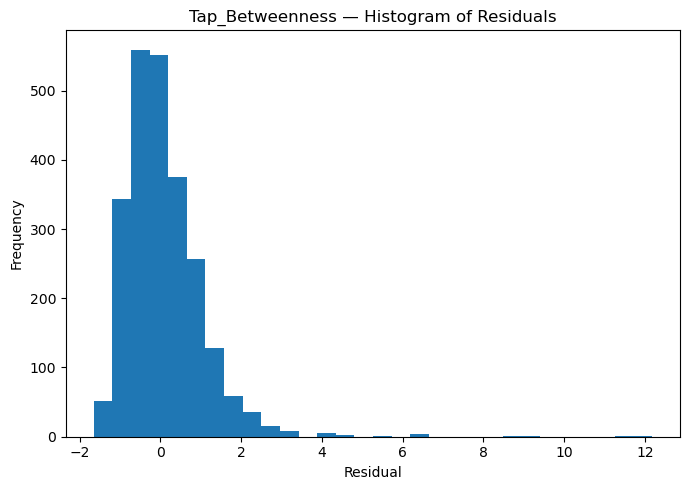

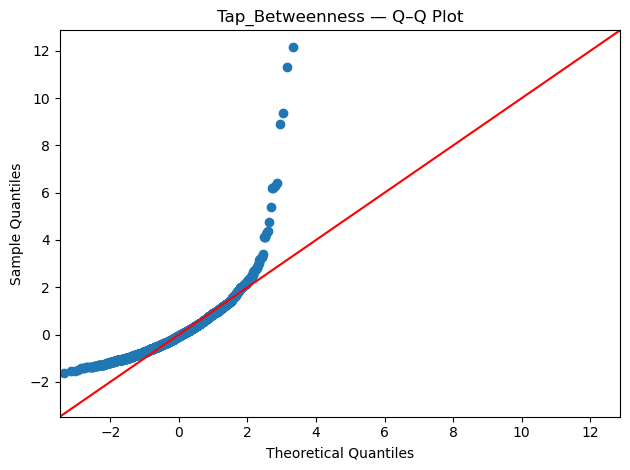

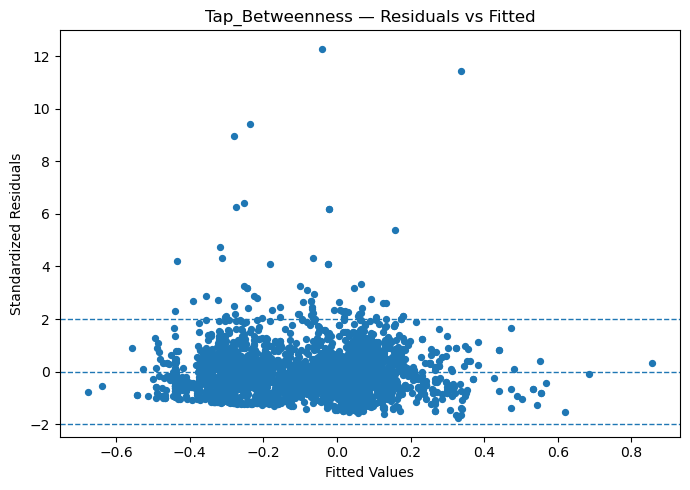

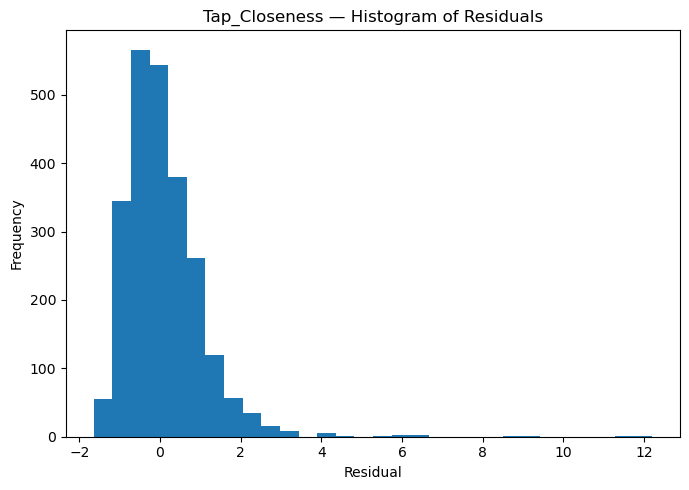

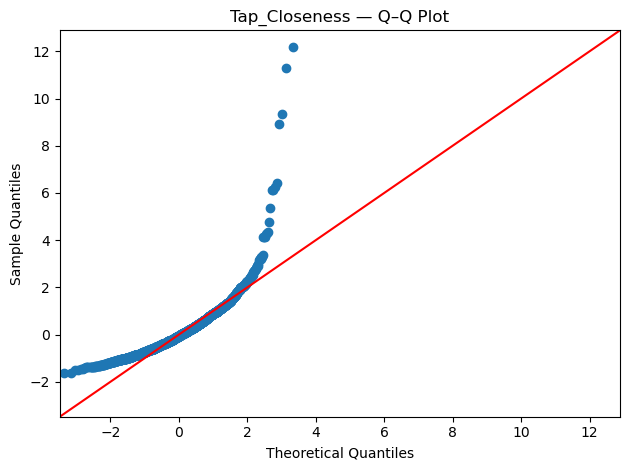

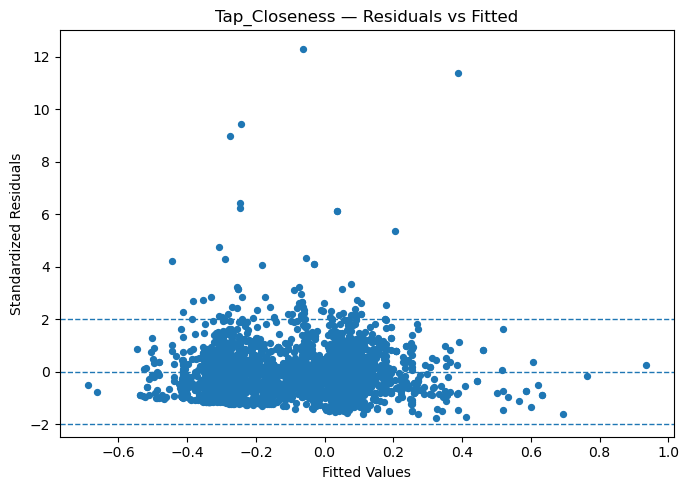

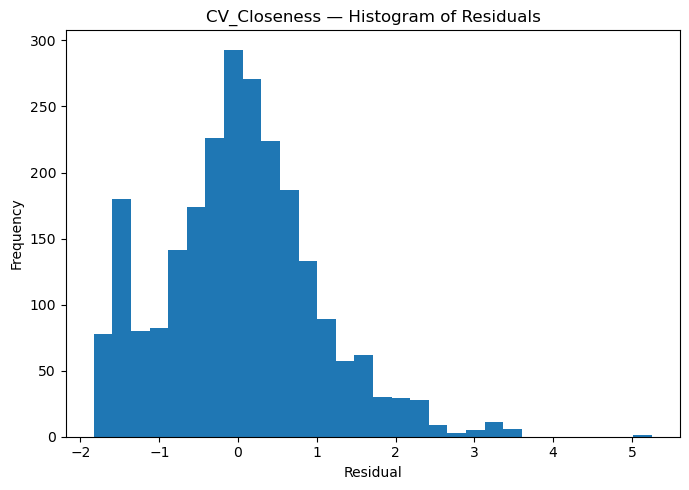

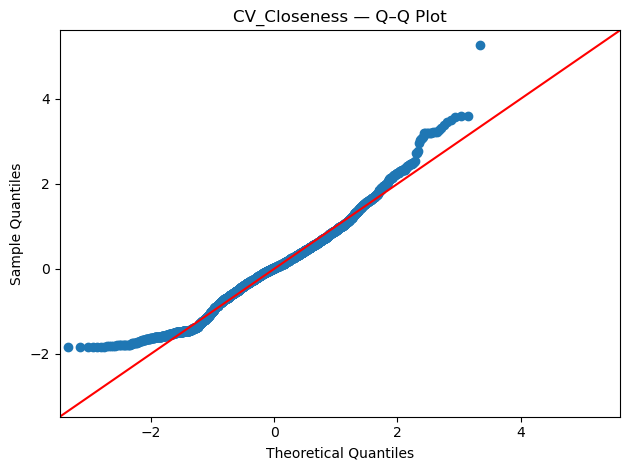

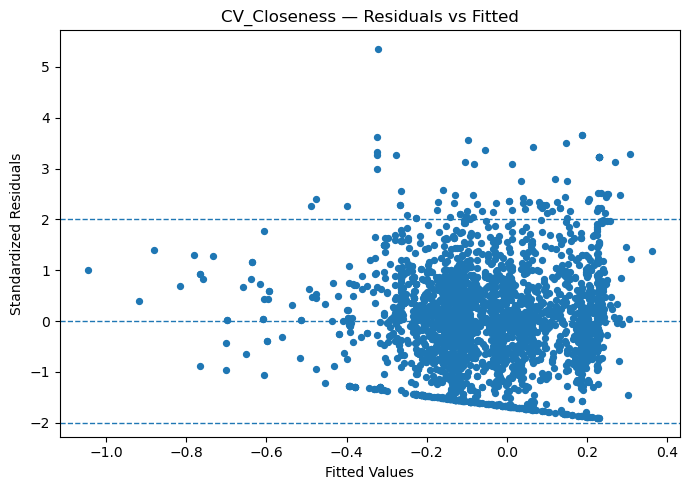

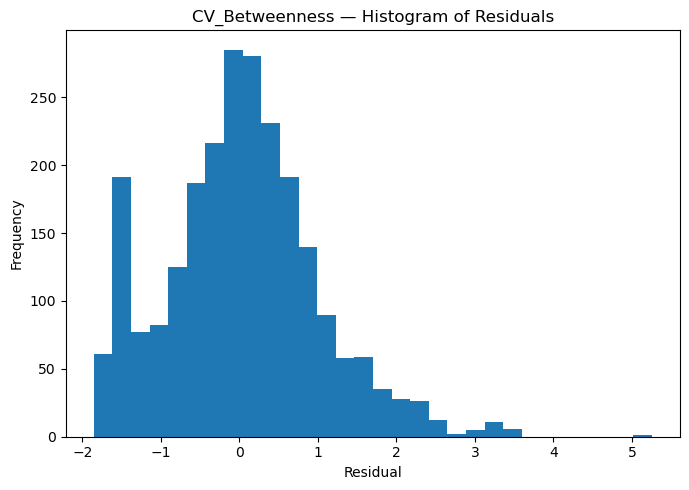

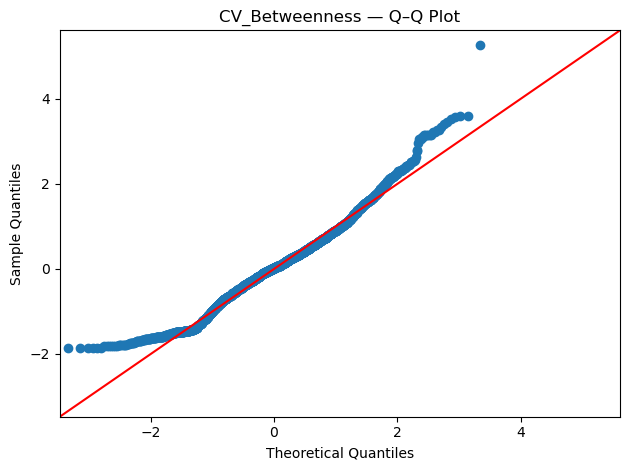

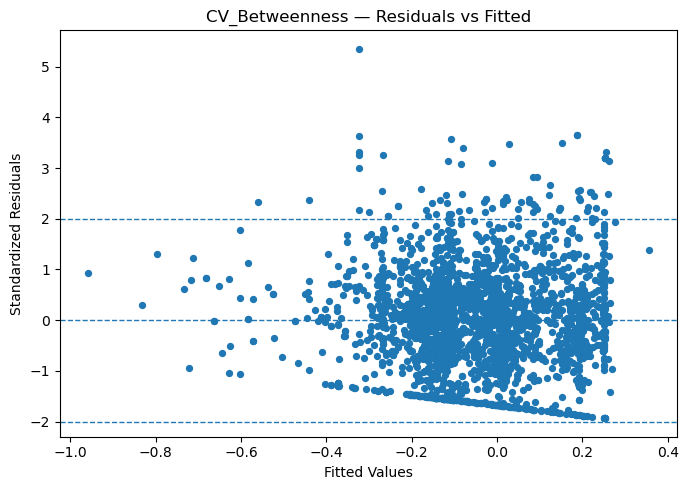


✅ Diagnostics saved under:
 → /Users/donatellazingaro/TSAS_Special_Issue_Urban_Mobility/notebooks/outputs/regression/regression/figs/diagnostics


In [19]:
# Directory for regression diagnostic figures
diag_dir = OUTPUT_DIR / "regression" / "figs" / "diagnostics"
diag_dir.mkdir(parents=True, exist_ok=True)

def diagnostics_plots(model, y, fitted_name_prefix):
    resid = y - model.fittedvalues
    standardized_resid = (resid - resid.mean()) / (resid.std(ddof=0) if resid.std(ddof=0) > 0 else 1.0)

    # 1️⃣ Histogram of residuals
    plt.figure(figsize=(7,5))
    plt.hist(resid, bins=30)
    plt.title(f"{fitted_name_prefix} — Histogram of Residuals")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(diag_dir / f"{fitted_name_prefix}_hist_residuals.png",
                dpi=300, bbox_inches='tight')
    plt.show()

    # 2️⃣ Q-Q plot
    fig = sm.qqplot(resid, line='45')
    plt.title(f"{fitted_name_prefix} — Q–Q Plot")
    plt.tight_layout()
    plt.savefig(diag_dir / f"{fitted_name_prefix}_qqplot.png",
                dpi=300, bbox_inches='tight')
    plt.show()

    # 3️⃣ Residuals vs Fitted
    plt.figure(figsize=(7,5))
    plt.scatter(model.fittedvalues, standardized_resid, s=18)
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.axhline(2, linestyle='--', linewidth=1)
    plt.axhline(-2, linestyle='--', linewidth=1)
    plt.title(f"{fitted_name_prefix} — Residuals vs Fitted")
    plt.xlabel("Fitted Values")
    plt.ylabel("Standardized Residuals")
    plt.tight_layout()
    plt.savefig(diag_dir / f"{fitted_name_prefix}_resid_vs_fitted.png",
                dpi=300, bbox_inches='tight')
    plt.show()

# Regenerate fitted models and run diagnostics
for name, spec in models_dict.items():
    y = df_clean[spec['target']].astype(float)
    X = df_clean[spec['predictors']].astype(float)
    model = fit_rlm(X, y)
    diagnostics_plots(model, y, fitted_name_prefix=name)

print(f"\n✅ Diagnostics saved under:\n → {diag_dir.resolve()}")
